# Diabetes prediction BRFSS 2021
**Author**: Axel Mezini
**Student ID**: 15742 
**Date**: 14/08/2024
## Introduction
In this notebook, we will use data from the [Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/index.html) to create a model for predicting diabetes. The BRFSS is a health-related survey conducted annually by the Centers for Disease Control and Prevention (CDC). It gathers data from adults across the United States on a wide range of health-related risk behaviors, chronic health conditions, and the use of preventive services. The goal is to develop a model that can help predicting diabetes, potentially aiding in earlier diagnosis and better patient outcomes. 
The steps involved in this analysis include:
- **Dataset analysis**: We will identify features that are most relevant to diabetes and its risk factors.
- **Preprocessing**: We will examine and clean the data, ensuring it's ready for modeling.
- **Feature Selection**: We will apply techniques to analyze and select the most important features that can contribute to predicting diabetes.
- **Modeling**: We will build and compare various classification models to evaluate their results and performance.

All necessary libraries are imported together to keep the code organized and readable. This includes:
- **numpy and pandas**: For data preprocessing and manipulation.
- **matplotlib and seaborn**: For creating visualizations and plotting data.
- **sklearn, imblearn, scipy, catboost and xgboost**: For performing machine learning tasks, including feature selection, model building and evaluation.
- **os**: utils

In [25]:
#Utils
import os
#Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#Feature selection
from sklearn.feature_selection import mutual_info_classif, chi2
from scipy.stats import pointbiserialr
#Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline as imPipeline
#Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
#Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score

We define global variables and configure options at the beginning to ensure consistency throughout the analysis and to simplify the management of key parameters. This includes a random seed for reproducibility and pandas options.

In [26]:
random_seed = 6 
filtered_dataset_path = 'data/diabetes_2021.csv'
pd.set_option('display.float_format', '{:.2f}'.format)

### Problem statement
Diabetes is a chronic condition that has significant health impacts, including the risk of heart disease, kidney failure, and vision loss. It affects millions of people globally, with increasing prevalence each year. Early identification of individuals at risk for diabetes is crucial for implementing preventive measures such as lifestyle changes or medications. By accurately predicting who might develop diabetes, healthcare providers can intervene earlier, improving patient outcomes, reducing long-term health complications, and lessening the overall burden on the healthcare system. 

### The dataset
The 2021 BRFSS dataset includes responses on health behaviors and conditions, lifestyle habits and diet, and access to health services. Data is collected through a series of telephone interviews with adults in all 50 states, the District of Columbia, and U.S. territories. The survey uses a combination of landline and cell phone interviews to reach a diverse demographic. The data is then subjected to an initial pre-processing procedure to ensure accuracy and reliability. This includes cleaning the data to address missing or inconsistent responses and calculating additional variables. More information can be found in the [Overview description](./docs/Overview_2021-508.pdf). The dataset can be found [here](https://www.cdc.gov/brfss/annual_data/annual_2021.html) as SAS transport format file (XPT extension). The idea originates from a [dataset repository on Kaggle](https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data?select=2015.csv), which  already preprocessed datasets up until the year 2015.

We read the SAS transport format to extract the data and print the shape. Go to the end of the section if the filtered dataset is already prepared.

In [27]:
if not os.path.isfile(filtered_dataset_path):   #Check if filtered dataset is available
    data = pd.read_sas('data/LLCP2021.XPT', format='xport') #Reads sas file
    print(data.shape)

The dataset contains 438693 records and 303 columns. Most of the columns are not related to diabetes and are therefore not relevant for our task. We print the column names to see the full list and select only those that may be relevant. Information on the columns can be found in the [Codebook description](docs/codebook21_llcp-v2-508.pdf) and in the [calculated variables' description](docs/2021-calculated-variables-version4-508.pdf). The following risk factors and other diabetes related information can be found in the [CDC - Diabetes](https://www.cdc.gov/diabetes/index.html) website.

In [28]:
if not os.path.isfile(filtered_dataset_path):
    print(data.columns.tolist())

 We divide the columns of our interest into seven categories: identifiers, demographics, health conditions, healthcare and medication utilization, lifestyle, dietary habits and target. Identifiers are needed only for duplicates' analysis, whereas all the other categories contain various information about the interviewed person. Target features contain information about both the presence of diabetes or pre-diabetes.

**Identifiers:**
- **SEQNO**: Annual sequence number

**Demographics:**
- **_STATE**: State FIPS code
- **_SEX**: Gender
- **_AGEG5YR**: Age category
- **_RACE**: Ethnicity
- **MARITAL**: Marital status
- **_EDUCAG**: Level of education category
- **EMPLOY1**: Employment status
- **_INCOMG1**: Annual household income category

**Health conditions:**
- **GENHLTH**: General health
- **MENTHLTH**: Number of days mental health not good
- **ADDEPEV3**: Ever told had a depressive disorder
- **PHYSHLTH**: Number of days physical health not good
- **_BMI5CAT**: Body mass index category
- **DIFFWALK**: Difficulty walking or climbing stairs
- **ASTHMA3**: Ever told had asthma
- **BPHIGH6**: Ever told blood pressure high
- **TOLDHI3**: Ever told cholesterol high
- **CVDINFR4**: Ever had a heart attack
- **CVDCRHD4**: Ever had a coronary heart disease
- **CVDSTRK3**: Ever had a stroke
- **CHCKDNY2**: Ever had kidney disease

**Healthcare and medications utilization:**
- **_HLTHPLN**: Has a source of health insurance
- **PERSDOC3**: Has personal health care provider
- **MEDCOST1**: Could not afford to see doctor
- **CHECKUP1**: Last routine checkup
- **EYEEXAM1**: Last eye exam where pupils were dilated
- **CHOLCHK3**: Last cholesterol check
- **BPMEDS**: Currently taking medicine for high blood pressure

**Lifestyle:**
- **EXERANY2**: Exercise past 30 days
- **SMOKDAY2**: Frequency of days now smoking
- **USENOW3**: Use of smokeless tobacco products
- **ECIGNOW1**: Frequency of days using e-cigarettes
- **SMOKE100**: Smoked at least 100 cigarettes in entire life
- **DROCDY3_**: Frequency of days drinking
- **DRNK3GE5**: Frequency of occasions as binge drinker

**Dietary habits:**
- **FRUTDA2_**: Fruit intake in times per day
- **FTJUDA2_**: Fruit juice intake in times per day
- **GRENDA1_**: Dark green vegetables intake in times per day
- **VEGEDA2_**: Other vegetables intake in times per day
- **FRNCHDA_**: French fries intake in times per day
- **POTADA1_**: Potato servings per day

**Target:**
- **DIABETE4**: Ever told have diabetes
- **PREDIAB1**: Ever told have pre-diabetes or borderline diabetes

In [29]:
if not os.path.isfile(filtered_dataset_path):    
    identifiers = ['SEQNO']
    demographics = ['_STATE', '_SEX', '_AGEG5YR', '_RACE', 'MARITAL', '_EDUCAG', 'EMPLOY1', '_INCOMG1']
    health = ['GENHLTH', 'MENTHLTH', 'ADDEPEV3', 'PHYSHLTH', '_BMI5CAT', 'DIFFWALK', 'ASTHMA3', 'BPHIGH6', 'TOLDHI3', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'CHCKDNY2']
    healthcare_medication_utilization = ['_HLTHPLN', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EYEEXAM1', 'CHOLCHK3', 'BPMEDS']
    lifestyle = ['EXERANY2', 'SMOKDAY2', 'USENOW3', 'ECIGNOW1', 'SMOKE100', 'DROCDY3_', 'DRNK3GE5']
    dietary_habits = ['FRUTDA2_', 'FTJUDA2_', 'GRENDA1_', 'VEGEDA2_', 'FRNCHDA_', 'POTADA1_']
    target = ['DIABETE4', 'PREDIAB1']
    
    data_diabetes = data[identifiers + demographics + health + healthcare_medication_utilization + lifestyle + dietary_habits + target]
    print(data_diabetes.shape)

Now we have a dataset with 44 features that may be relevant for predicting diabetes. We rename them to make the names more descriptive and export it into a csv file for easier access. 

In [30]:
if not os.path.isfile(filtered_dataset_path):    
    new_names = ['sequence_nr', 'state', 'gender', 'age', 'ethnicity', 'marital', 'education', 'employment', 'income', 'general_health', 'mental_health', 'depressive_disorder', 'physical_health', 'bmi_cat', 'difficulty_walking', 'has_asthma', 'high_blood_press', 'high_cholesterol', 'had_heart_attack', 'had_coronary_heart', 'had_stroke', 'had_kidney_disease', 'health_insurance_source', 'health_care_provider', 'cannot_afford_doctor', 'routine_checkup', 'eye_exam', 'cholesterol_check', 'meds_high_pressure', 'did_exercise', 'smoking_freq', 'use_smokeless', 'use_e_cigarettes', 'smoked100', 'drink_day', 'binge_drink', 'fruits_day', 'fruits_juice_day', 'green_vegetables_day', 'other_vegetables_day', 'french_fries_day', 'potatoes_day', 'has_diabetes', 'has_pre_diabetes']

    data_diabetes = data_diabetes.set_axis(new_names, axis=1)   #Replaces column names
    data_diabetes.to_csv('data/diabetes_2021.csv', index=False) #Writes to csv

This is the starting point of our in-depth analysis of the dataset that contains only information of or interest.

In [31]:
data_diabetes = pd.read_csv('data/diabetes_2021.csv')   #Reads csv file
data_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438693 entries, 0 to 438692
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sequence_nr              438693 non-null  object 
 1   state                    438693 non-null  float64
 2   gender                   438693 non-null  float64
 3   age                      438693 non-null  float64
 4   ethnicity                438693 non-null  float64
 5   marital                  438688 non-null  float64
 6   education                438693 non-null  float64
 7   employment               435105 non-null  float64
 8   income                   438693 non-null  float64
 9   general_health           438689 non-null  float64
 10  mental_health            438691 non-null  float64
 11  depressive_disorder      438690 non-null  float64
 12  physical_health          438690 non-null  float64
 13  bmi_cat                  391841 non-null  float64
 14  diff

Among the 44 columns, most of them are numeric, only one is of object type. Many columns contain missing values, which we will handle during the preprocessing. We can print the first ten rows to see how the data is structured.

In [32]:
data_diabetes.head(n=10)

,sequence_nr,state,gender,age,ethnicity,marital,education,employment,income,general_health,...,drink_day,binge_drink,fruits_day,fruits_juice_day,green_vegetables_day,other_vegetables_day,french_fries_day,potatoes_day,has_diabetes,has_pre_diabetes
0,b'2021000001',1.00,2.00,11.00,1.00,1.00,2.00,7.00,3.00,5.00,...,0.00,NaN,100.00,0.00,57.00,100.00,43.00,14.00,3.00,3.00
1,b'2021000002',1.00,2.00,10.00,2.00,9.00,4.00,8.00,9.00,3.00,...,0.00,NaN,100.00,0.00,14.00,100.00,0.00,14.00,1.00,NaN
2,b'2021000003',1.00,2.00,11.00,2.00,3.00,2.00,7.00,2.00,2.00,...,0.00,NaN,100.00,0.00,0.00,43.00,14.00,14.00,1.00,NaN
3,b'2021000004',1.00,2.00,9.00,1.00,1.00,2.00,7.00,5.00,2.00,...,14.00,1.00,43.00,71.00,10.00,71.00,57.00,27.00,1.00,NaN
4,b'2021000005',1.00,1.00,12.00,7.00,1.00,1.00,8.00,2.00,5.00,...,0.00,NaN,100.00,0.00,100.00,100.00,29.00,29.00,1.00,NaN
5,b'2021000006',1.00,1.00,13.00,1.00,1.00,3.00,7.00,4.00,3.00,...,0.00,NaN,29.00,0.00,14.00,14.00,0.00,14.00,3.00,3.00
6,b'2021000007',1.00,1.00,9.00,1.00,1.00,4.00,8.00,9.00,3.00,...,0.00,NaN,40.00,3.00,43.00,29.00,43.00,7.00,3.00,3.00
7,b'2021000008',1.00,1.00,9.00,1.00,2.00,1.00,2.00,9.00,4.00,...,0.00,NaN,57.00,0.00,29.00,57.00,0.00,57.00,3.00,3.00
8,b'2021000009',1.00,2.00,12.00,1.00,2.00,1.00,7.00,9.00,2.00,...,0.00,NaN,29.00,100.00,0.00,29.00,NaN,0.00,3.00,3.00
9,b'2021000010',1.00,2.00,10.00,1.00,1.00,2.00,7.00,5.00,3.00,...,10.00,88.00,100.00,0.00,29.00,57.00,29.00,43.00,3.00,3.00


## Preprocessing
In this section we will focus on exploring and cleaning the data contained in the dataset. We will investigate the presence of duplicates and outliers, handle missing values, clean the content of the columns and perform feature engineering. This is crucial to ensure data quality and suitability for accurate and effective analysis and modeling.

### Duplicates
Removing duplicates is crucial for accuracy and data integrity of our task. We use the combination of the columns *state* and *sequence_number* as the unique identifier, since each state has its own unique code and individual sequencing. We do not consider different respondents, that answer each question in the same way, as duplicates, avoiding loss of valuable data.

In [33]:
print(data_diabetes.duplicated(subset=['state', 'sequence_nr']).sum())  #Counts number of duplicates

0


The dataset does not contain any duplicate identifier. We remove the *sequence_nr* since it is only an identifier, but keep the *state*.

In [34]:
data_diabetes = data_diabetes.drop(columns=['sequence_nr']) #Removes columns

### Data cleaning
Many columns contain responses such as 'do not know', 'do not remember', or 'refused to answer', which we consider as missing values. Several columns are have a categorical nature but contain numerical values. We map these values into meaningful categories to enhance readability for subsequent analysis. We also adjust the scale of some numeric columns to ensure consistency. We define the most common mappings in the following cell.

In [35]:
yes_no_mapping = {1: 'yes', 2: 'no', 7: np.nan, 9: np.nan}
times_mapping = {77: np.nan, 88: 0, 99: np.nan}
smoke_frequency_mapping = {1: 'every-day', 2: 'some-days', 3: 'never', 7: np.nan, 9: np.nan}

**Demographics:**
- **Missing values mapping**: *age*, *ethnicity*, *marital*, *education*, *employment*, *income*
- **Categorical mapping**: *gender*, *age*, *ethnicity*, *marital*, *education*, *employment*, *income*

In [36]:
data_diabetes = data_diabetes.replace({ #Replaces values
    'gender': {1: 'male', 2: 'female'},
    'age': {1: '18-29', 2: '18-29', 3: '30-39', 4: '30-39', 5: '40-49', 6: '40-49', 7: '50-59', 8: '50-59', 9: '60-69', 10: '60-69', 11: '70-79',
            12: '70-79', 13: '>=80', 14: np.nan},
    'ethnicity': {1: 'white', 2: 'black', 3: 'american-alaskan', 4: 'asian', 5: 'hawaiian-pacific', 6: 'other', 7: 'multiracial', 8: 'hispanic', 9: np.nan},
    'marital': {1: 'married', 2: 'divorced', 3: 'widowed', 4:'separated', 5: 'single', 6: 'couple', 9: np.nan},
    'education': {1: 'not-high-school', 2: 'high-school', 3: 'some-college', 4: 'college', 9: np.nan},
    'employment': {1: 'employed', 2: 'self-employed', 3: 'out-of-work', 4: 'out-of-work', 5: 'homemaker', 6: 'student', 7: 'retired', 8: 'unable', 
                   9: np.nan},
    'income': {1: '<15k', 2: '15k-25k', 3: '25k-35k', 4: '35k-50k', 5: '50k-100k', 6: '100k<200k', 7: '>200k', 9: np.nan}
})
data_diabetes['state'] = data_diabetes['state'].astype('object')


**Health conditions:**
- **Missing values mapping**: *general_health*, *mental_health*, *depressive_disorder*, *physical_health*, *difficulty_walking*, *has_asthma*, *high_blood_press*, *high_cholesterol*, *had_heart_attack*, *had_coronary_heart*, *had_stroke*, *had_kidney_disease*
- **Categorical mapping**: *general_health*, *depressive_disorder*, *bmi_cat*, *difficulty_walking*, *has_asthma*, *high_blood_press*, *high_cholesterol*, *had_heart_attack*, *had_coronary_heart*, *had_stroke*, *had_kidney_disease*

In [37]:
data_diabetes = data_diabetes.replace({
    'general_health': {1: 'excellent', 2: 'very-good', 3: 'good', 4: 'fair', 5: 'poor', 7: np.nan, 9: np.nan},
    'mental_health': times_mapping,
    'depressive_disorder': yes_no_mapping,
    'physical_health': times_mapping,
    'bmi_cat': {1: 'underweight', 2: 'normal', 3: 'over', 4: 'obese'},
    'difficulty_walking': yes_no_mapping,
    'has_asthma': yes_no_mapping,
    'high_blood_press': {1: 'yes', 2: 'only-pregnancy', 3: 'no', 4: 'borderline', 7: np.nan, 9: np.nan},
    'high_cholesterol': yes_no_mapping,
    'had_heart_attack': yes_no_mapping,
    'had_coronary_heart': yes_no_mapping,
    'had_stroke': yes_no_mapping,
    'had_kidney_disease': yes_no_mapping
})

**Healthcare and medications utilization:**
- **Missing values mapping**: *health_insurance_source*, *health_care_provider*, *cannot_afford_doctor*, *routine_checkup*, *eye_exam*, *cholesterol_check*, *meds_high_pressure*
- **Categorical mapping**: *health_insurance_source*, *health_care_provider*, *cannot_afford_doctor*, *routine_checkup*, *eye_exam*, *cholesterol_check*, *meds_high_pressure*

In [38]:
data_diabetes = data_diabetes.replace({
    'health_insurance_source': yes_no_mapping,
    'health_care_provider': {1: 'one', 2: 'multiple', 3: 'no', 7: np.nan, 9: np.nan},
    'cannot_afford_doctor': yes_no_mapping,
    'routine_checkup': {1: '<1year', 2: '1-2years', 3: '2-5years', 4: '>5years', 7: np.nan, 8: 'never', 9: np.nan},
    'eye_exam': {1: '<1month', 2: '<1year', 3: '1-2years', 4: '>2years', 7: np.nan, 8: 'never', 9: np.nan},
    'cholesterol_check': {1: 'never', 2: '<1year', 3: '1-2years', 4: '2-3years', 5: '3-4years', 6: '4-5years', 7: np.nan, 8: '>5years', 9: np.nan},
    'meds_high_pressure': yes_no_mapping
})




**Lifestyle:**
- **Missing values mapping**: *did_exercise*, *smoking_freq*, *use_smokeless*, *use_e_cigarettes*, *smoked100*, *drink_day*, *binge_drink*
- **Categorical mapping**: *did_exercise*, *smoking_freq*, *use_smokeless*, *use_e_cigarettes*, *smoked100*, *binge_drink*
- **Value scaling**: *drink_day*

In [39]:
data_diabetes = data_diabetes.replace({
    'did_exercise': yes_no_mapping,
    'smoking_freq': smoke_frequency_mapping,
    'use_smokeless': smoke_frequency_mapping,
    'use_e_cigarettes': {1: 'every-day', 2: 'some-days', 3: 'never', 4: 'never', 7: np.nan, 9: np.nan},
    'smoked100': yes_no_mapping,
    'drink_day': {900: np.nan},
    'binge_drink': times_mapping
})
data_diabetes['drink_week'] = data_diabetes['drink_day'] / 100 * 7
data_diabetes = data_diabetes.drop(columns=['drink_day'])


**Dietary habits:** 
- **Value scaling**: *fruits_day*, *fruits_juice_day*, *green_vegetables_day*, *other_vegetables_day*, *french_fries_day*, *potatoes_day*

In [40]:
for column in ['fruits_day', 'fruits_juice_day', 'green_vegetables_day', 'other_vegetables_day', 'french_fries_day','potatoes_day']:
    data_diabetes[column] = data_diabetes[column] / 100

**Target:**
- **Missing values mapping**: *has_diabetes*, *has_pre_diabetes*
- **Categorical mapping**: *has_diabetes*, *has_pre_diabetes*

In [41]:
data_diabetes = data_diabetes.replace({
    'has_diabetes': {1: 'yes', 2: 'no', 3: 'no', 4: 'yes', 7: np.nan, 9: np.nan},
    'has_pre_diabetes': {1: 'yes', 2: 'no', 3: 'no', 7: np.nan, 9: np.nan}
})

### Combining columns
Before handling the missing values, we combine some columns to create new features. This allows us to extract some information before removing them in the next step.
The new feature *smokes_any* is a combination of the columns *smoking_freq*, *use_smokeless* and *use_e_cigarettes*. It identifies respondents who take nicotine or other harmful substances by smoking regular or electronic cigarettes or using smokeless products.

In [42]:
def smokes_any(record):
    smoking_columns = ['smoking_freq', 'use_smokeless', 'use_e_cigarettes']
    
    if all(pd.isna(record[column]) for column in smoking_columns):  #Checks for completeness
        return np.nan
    if any(record[column] in ['every-day', 'some-days'] for column in smoking_columns): #Checks for existence
        return 'yes'
    return 'no'

data_diabetes['smokes_any'] = data_diabetes.apply(smokes_any, axis=1)   #Applies a function to a column
data_diabetes = data_diabetes.drop(columns=['smoking_freq', 'use_smokeless', 'use_e_cigarettes'])

The new feature *diabetes* is a combination of the two target columns *has_diabetes* and *has_pre_diabetes*. It identifies respondents that have one of the two health conditions. Treating them together, we want to capture a broader spectrum of glucose dysregulation.

In [43]:
def determine_diabetes(record):
    diabetes_columns = ['has_diabetes', 'has_pre_diabetes']
    
    if all(pd.isna(record[column]) for column in diabetes_columns):
        return np.nan
    if any(record[column] == 'yes' for column in diabetes_columns):
        return 'yes'
    else:
        return 'no'
        
data_diabetes['diabetes'] = data_diabetes.apply(determine_diabetes, axis=1)
data_diabetes = data_diabetes.drop(columns=['has_diabetes', 'has_pre_diabetes'])

No we can investigate the distribution of our target variable.

Proportion of 'yes': 18.15%


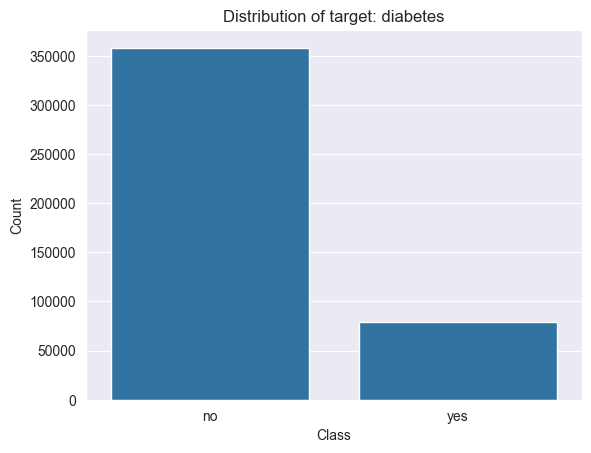

In [44]:
print(f"Proportion of 'yes': {(data_diabetes['diabetes'] == 'yes').sum() / len(data_diabetes):.2%}")

sns.countplot(data=data_diabetes, x='diabetes') #Plots a bar plot
plt.title('Distribution of target: diabetes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

There is a clear imbalance in the distribution of the two classes, with the positive class being the minority. The proportion of individuals with diabetes is 19.60%. This proportion represents the probability of correctly predicting the diabetes class by random guessing.

### Missing values
Given our limited domain knowledge and the categorical nature of most columns, we will not impute missing values. Instead, we will remove columns where the percentage of missing values exceeds 15%, and we will eliminate rows that contain any missing values for the remaining ones. This threshold allows us to retain valuable features while minimizing the impact of missing data. 

In [45]:
high_null_columns = []
rows = []
for column in data_diabetes.columns:
    num_nulls = data_diabetes[column].isnull().sum()
    percent_nulls = data_diabetes[column].isnull().mean() * 100
    if percent_nulls > 15:
        high_null_columns.append(column)
    rows.append({'Column': column, 'Null values count': num_nulls, 'Null values %': percent_nulls})

pd.DataFrame(rows).sort_values(by='Null values %', ascending=False)  #Creates new dataframe

,Column,Null values count,Null values %
25,eye_exam,416960,95.05
27,meds_high_pressure,267019,60.87
30,binge_drink,232194,52.93
7,income,94413,21.52
16,high_cholesterol,63980,14.58
34,other_vegetables_day,48528,11.06
36,potatoes_day,48440,11.04
12,bmi_cat,46852,10.68
35,french_fries_day,44765,10.20
32,fruits_juice_day,44349,10.11


The columns with most missing values are *eye_exam* (95.05%), *meds_high_pressure* (60,87%), *binge_drink* (52.93%) and *income* (21.52%). We remove these columns completely and delete the remaining rows containing null values. 

In [46]:
data_diabetes = data_diabetes.drop(columns=high_null_columns)
data_diabetes = data_diabetes.dropna()  #Drops all missing values
data_diabetes.shape

(263593, 36)

### Outliers
We examine the data for outliers that may introduce noise and affect the quality of our analysis. 

For the numeric columns we can print a summary that provides us the important statistics.

In [47]:
data_diabetes.describe()

,mental_health,physical_health,fruits_day,fruits_juice_day,green_vegetables_day,other_vegetables_day,french_fries_day,potatoes_day,drink_week
count,263593.00,263593.00,263593.00,263593.00,263593.00,263593.00,263593.00,263593.00,263593.00
mean,3.84,3.72,1.34,0.42,0.80,1.38,0.24,0.28,1.22
std,7.81,8.22,4.82,3.45,4.57,6.26,1.51,1.63,1.97
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.43,0.00,0.14,0.43,0.03,0.07,0.00
50%,0.00,0.00,1.00,0.03,0.43,1.00,0.14,0.14,0.21
75%,3.00,2.00,1.00,0.29,0.71,1.00,0.29,0.29,1.40
max,30.00,30.00,99.00,99.00,99.00,99.00,99.00,99.00,7.00


All the dietary features have max value of 99, which would mean 99 portions a day. This seems to be an input error during the compilation of the questionnaire. We can further analyse their distribution using boxplots.

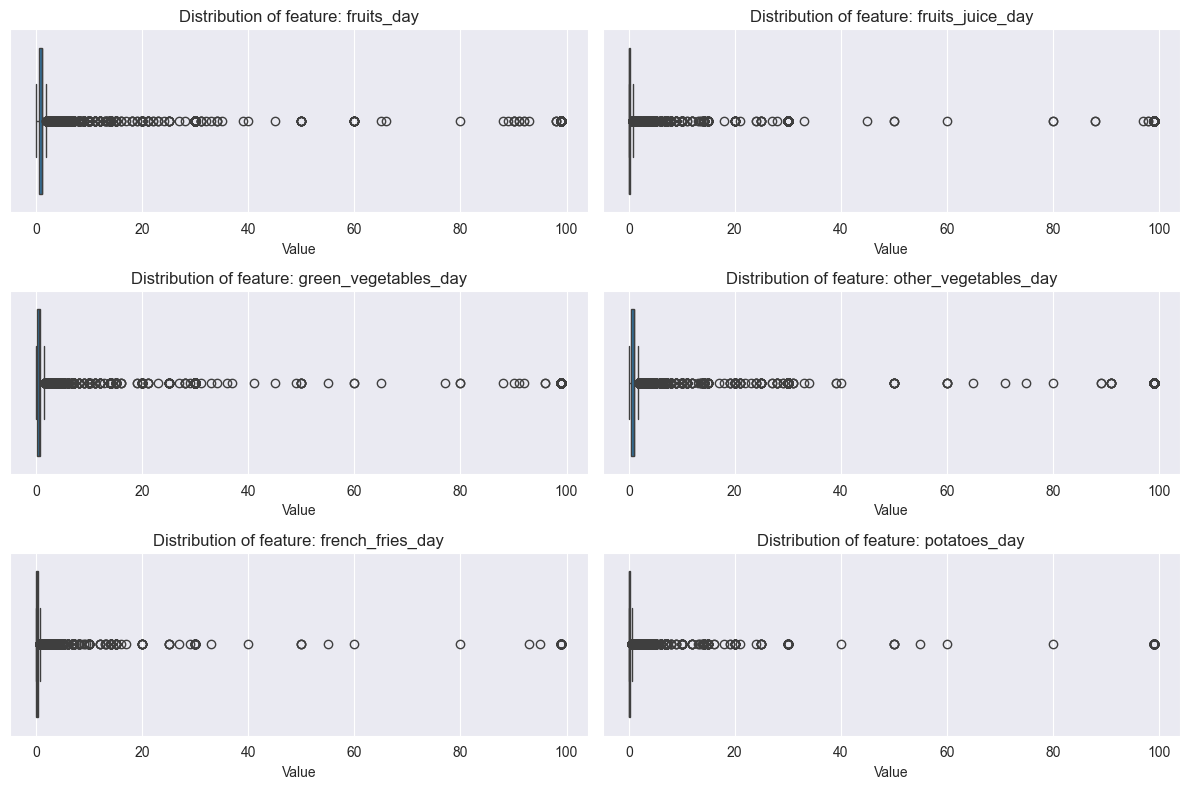

In [48]:
variables_food = ['fruits_day', 'fruits_juice_day', 'green_vegetables_day', 'other_vegetables_day', 'french_fries_day', 'potatoes_day']

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(variables_food):
    sns.boxplot(data=data_diabetes, x=var, ax=axes[i])  #Plots a box plot
    axes[i].set_title(f'Distribution of feature: {var}')
    axes[i].set_xlabel('Value')

plt.tight_layout()
plt.show()

All these columns have several values that are very high and not realistic. We cap the number of daily portions to 7, removing all the rest.

In [118]:
for column in variables_food:
    data_diabetes = data_diabetes[(data_diabetes[column] <= 7)] #Filters out by condition
data_diabetes.shape

(247435, 36)

The variables *mental_health*, *physical_health*, and *drink_week* show outliers with maximum values of 30, 30, and 7, respectively. Given that the first two variables are measured on a monthly scale and the third on a weekly scale, these maximum values are considered valid. We will proceed to categorize these features in the next step.

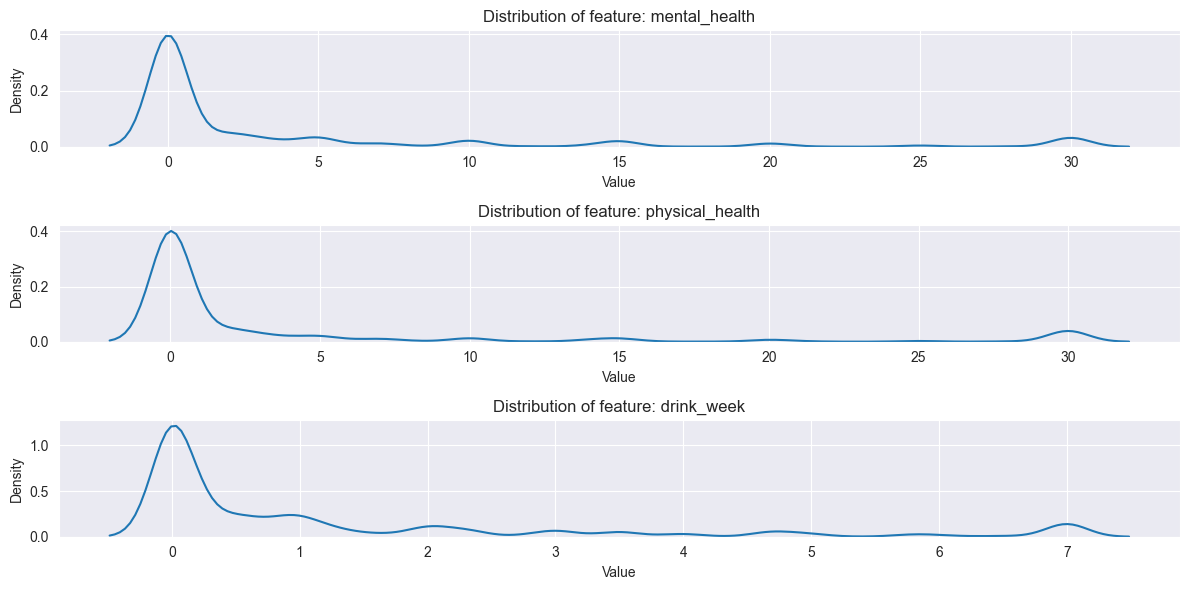

In [256]:
variables_time = ['mental_health', 'physical_health', 'drink_week']

fig, axes = plt.subplots(3, 1, figsize=(12, 6))
axes = axes.flatten() 

for i, var in enumerate(variables_time):
    sns.kdeplot(data_diabetes[var], ax=axes[i]) #Plots a kernel density plot
    axes[i].set_title(f'Distribution of feature: {var}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

We observe that values for all three features are clustered around zero. After binning these features, we will assess the frequencies of each category. 

For categorical columns, we consider classes that appear very rarely as outliers. We will investigate if any feature has a mode that occurs more than 99.5% or if it contains any class that appears in less than 0.5% of the records. 

In [257]:
rows = []
for column in data_diabetes.select_dtypes(include=['object']).columns:
    mode = data_diabetes[column].mode()[0]
    frequency = data_diabetes[column].value_counts().iloc[0] / len(data_diabetes) * 100
    rows.append({'Column': column, 'Unique count': len(data_diabetes[column].unique()), 'Mode': mode, 'Mode Frequency %': frequency})

pd.DataFrame(rows).sort_values(by='Mode Frequency %', ascending=False)

,Column,Unique count,Mode,Mode Frequency %
18,health_insurance_source,2,yes,96.27
16,had_stroke,2,no,96.09
17,had_kidney_disease,2,no,95.87
14,had_heart_attack,2,no,94.65
15,had_coronary_heart,2,no,94.26
20,cannot_afford_doctor,2,no,93.89
11,has_asthma,2,no,86.05
10,difficulty_walking,2,no,84.53
25,smokes_any,2,no,83.42
21,routine_checkup,5,<1year,80.93


The dataset contains features with a very high dominance up to 96.27%, but not more than 99.5%. Now we analyse the frequencies of each class individually.

In [50]:
rows = []
for column in data_diabetes.select_dtypes(include=['object']).columns:
    value_counts = data_diabetes[column].value_counts()
    frequency_percentage = (value_counts / len(data_diabetes)) * 100
    low_freq_values = frequency_percentage[frequency_percentage < 0.5]

    if not low_freq_values.empty:
        for value, percentage in low_freq_values.items():
            count = value_counts.get(value, 0) 
            rows.append({'Column': column, 'Value': value, 'Count': count, 'Percentage': percentage})

pd.DataFrame(rows)

,Column,Value,Count,Percentage
0,state,66.00,1061,0.41
1,state,78.00,779,0.30
2,ethnicity,hawaiian-pacific,1128,0.43
3,routine_checkup,never,525,0.20


The value 'hawaiian-pacific' in the *ethnicity* column appears only 0.43% of the times and the value 'never' in the *routine_checkup* column appears only 0.2% of the times. We plot their distributions of to check the frequency of additional classes. In addition, the *state* column contains two values that apper less than 0.5% of the times.

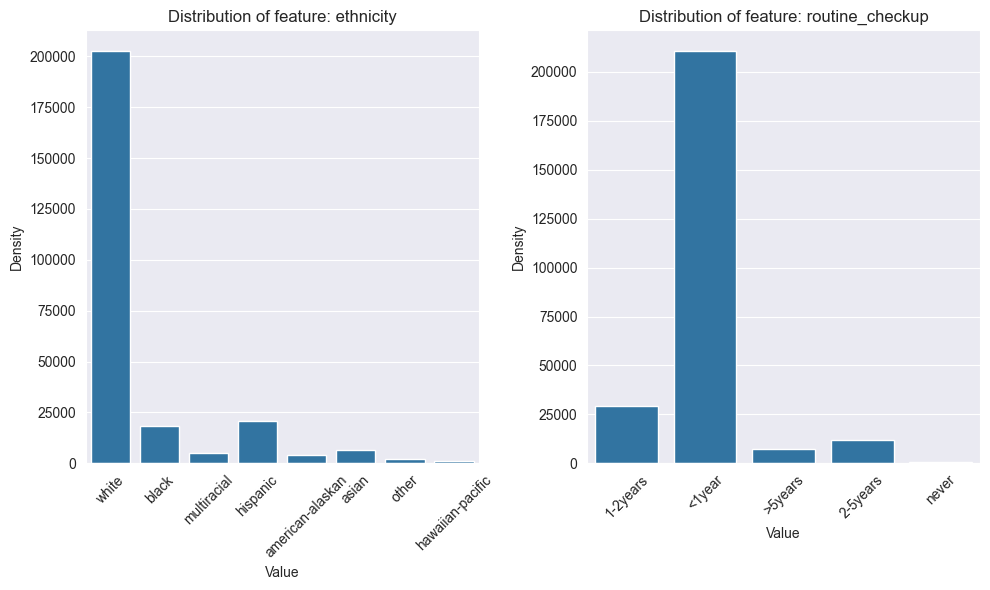

In [261]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes = axes.flatten() 

for i, var in enumerate(['ethnicity', 'routine_checkup']):
    sns.countplot(data=data_diabetes, x=var, ax=axes[i]) 
    axes[i].set_title(f'Distribution of feature: {var}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

Even tough there are other classes that are rare in comparison to the mode, they are not lower than the minimum limit of 0.5%. We remove the rows containing these values.

In [54]:
data_diabetes = data_diabetes[data_diabetes['ethnicity'] != 'hawaiian-pacific']
data_diabetes = data_diabetes[data_diabetes['routine_checkup'] != 'never']
data_diabetes = data_diabetes[data_diabetes['state'] != 66]
data_diabetes = data_diabetes[data_diabetes['state'] != 78]
data_diabetes.shape

(257133, 36)

### Categorization
As mentioned before, we use bins to categorize the three numeric columns that have a weekly/monthly scale.
 
For *mental_health* and *physical_health* we create 5 days ranges and the no day class. 

In [55]:
bins = [-0.1, 0.1, 5.01, 10.01, 15.01, 20.01, 25.01, 30.01]
labels = ['none', '1-5', '5-10', '10-15', '15-20', '20-25', '>25']

data_diabetes['mental_health_cat'] = pd.cut(data_diabetes['mental_health'], bins=bins, labels=labels)   #Cuts numeric variable in bins
data_diabetes['physical_health_cat'] = pd.cut(data_diabetes['physical_health'], bins=bins, labels=labels)

data_diabetes = data_diabetes.drop(columns=['mental_health', 'physical_health'])

For *drink_week* we create a category for each number of days and the no day class.

In [56]:
bins = [-0.1, 0.1, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01]
labels = ['none', '1', '2', '3', '4', '5', '6', '7']

data_diabetes['drink_week_cat'] = pd.cut(data_diabetes['drink_week'], bins=bins, labels=labels)
data_diabetes = data_diabetes.drop(columns=['drink_week'])

We know can analyse the frequencies of these new bins to check the presence of outliers.

In [57]:
rows = []
for column in ['mental_health_cat', 'physical_health_cat', 'drink_week_cat']:
    value_counts = data_diabetes[column].value_counts()
    frequency_percentage = (value_counts / len(data_diabetes)) * 100

    for value, count in value_counts.items():
        percentage = frequency_percentage[value]
        rows.append({'Column': column, 'Value': value, 'Count': count, 'Percentage': percentage})

pd.DataFrame(rows).sort_values(by='Percentage')

,Column,Value,Count,Percentage
13,physical_health_cat,20-25,1851,0.72
6,mental_health_cat,20-25,2154,0.84
21,drink_week_cat,6,2617,1.02
12,physical_health_cat,15-20,3250,1.26
5,mental_health_cat,15-20,4958,1.93
11,physical_health_cat,10-15,7536,2.93
20,drink_week_cat,5,8314,3.23
19,drink_week_cat,4,8556,3.33
4,mental_health_cat,10-15,10029,3.90
10,physical_health_cat,5-10,11273,4.38


There is no value that appears less than 0.5% of the time.

In [119]:
data_clean = data_diabetes.copy()

## Feature selection
In this section, we will apply various techniques to examine the relationship between each feature and the target variable. This is not only important for understanding each feature impact, but also for model performance and complexity optimization.

To do so, we encode the categorical features, and separate them from the numeric ones.

In [112]:
data_encoded = data_clean.copy()

categorical_columns = data_encoded.select_dtypes(include=['object', 'category']).columns
numeric_columns = data_encoded.select_dtypes(include=['Int64', 'float64']).columns

le = LabelEncoder() #Encodes categorical columns into numeric
for column in categorical_columns:
    data_encoded[column] = le.fit_transform(data_encoded[column])   

y = data_encoded['diabetes']

### Mutual information
This technique measures the mutual dependence between two variables, quantifying the "amount of information" obtained about one variable by observing the other one. This concept is closely related to variable entropy. We apply this technique separately for numeric and categorical features, as the calculation methods differ for each type.

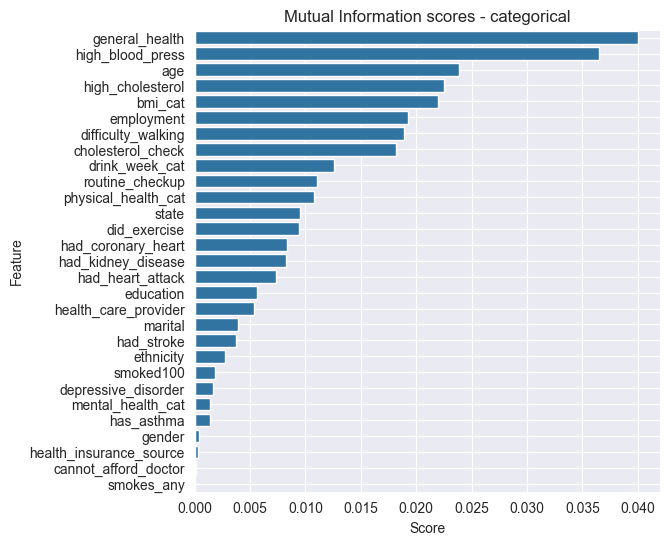

In [60]:
X = data_encoded[categorical_columns].drop(columns=['diabetes'])

mi_scores = mutual_info_classif(X, y, discrete_features=True, random_state=random_seed)
mi_df = pd.DataFrame({'Feature': X.columns, 'Score': mi_scores}).sort_values(by='Score', ascending=False) 

plt.figure(figsize=(6, 6))
sns.barplot(data=mi_df, y='Feature', x='Score')

plt.title('Mutual Information scores - categorical')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

The categorical features that are more related to the target are *general_health* and *high_blood_press* with very high scores, whereas *smokes_any*, *cannot_afford_doctor* and *health_insurance_source* are the less related features with score of approximately zero.  

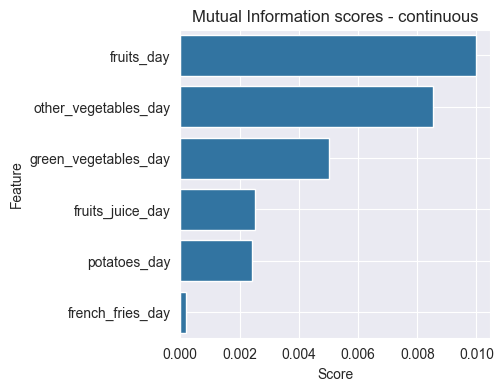

In [61]:
X = data_encoded[numeric_columns]

mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=random_seed)
mi_df = pd.DataFrame({'Feature': X.columns, 'Score': mi_scores}).sort_values(by='Score', ascending=False) 

plt.figure(figsize=(4, 4))
sns.barplot(data=mi_df, y='Feature', x='Score')

plt.title('Mutual Information scores - continuous')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

The numeric feature that is more related to the target is *fruits_day*, whereas the less related is *french_fries_day*.

### Chi-squared test
This test is a statistical hypothesis test used in the analysis of contingency tables. It is primarily used to examine whether two categorical variables are independent or if there exists a significant association between them.

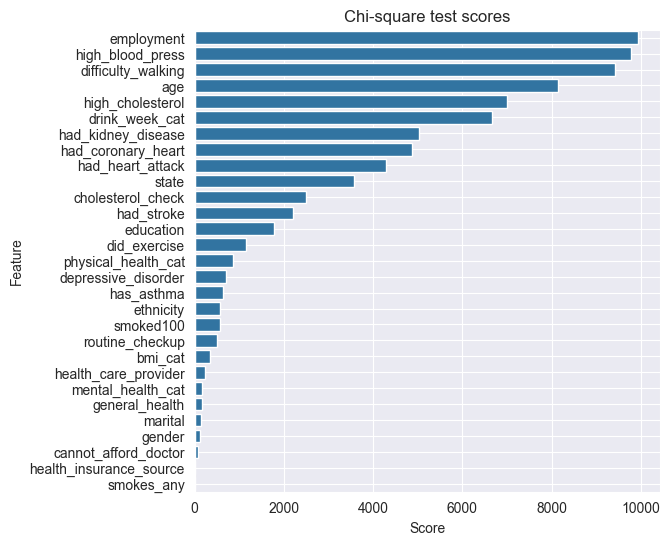

In [62]:
X = data_encoded[categorical_columns].drop(columns=['diabetes'])

chi_scores, _ = chi2(X, y)
chi2_df = pd.DataFrame({'Feature': X.columns, 'Score': chi_scores}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(data=chi2_df, y='Feature', x='Score')

plt.title('Chi-square test scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

The feature *employment* is the most related with *high_blood_press* that scores again high in second place. The last three places are occupied by the same variables as before.

### Point-biserial correlation
This correlation is a coefficient used when one variable is dichotomous. Mathematically, it is equivalent to the Pearson correlation coefficient, but is applied to this particular scenario. It measures the strength and direction of the association between a continuous numeric variable and a binary categorical variable. 

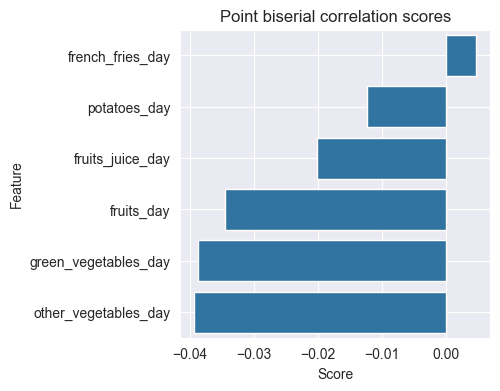

In [64]:
X = data_encoded[numeric_columns]

correlations = {}
for feature in X.columns:
    corr, _ = pointbiserialr(X[feature], y)
    correlations[feature] = corr

corr_df = pd.DataFrame({'Feature': list(correlations.keys()), 'Score': list(correlations.values())}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(4, 4))
sns.barplot(data=corr_df, y='Feature', x='Score')

plt.title('Point biserial correlation scores')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

This time *other_vegetables_day* is the best scoring column, whereas as before, *french_fries_day* has the lowest coefficient with an absolute value near to zero. Negative values show a negative correlation.

We look at the distributions of the most and less related features using bar plots and histograms.

In [65]:
def plot_categorical_relation(data, column):
    contingency_table = pd.crosstab(data[column], data['diabetes'])
    contingency_table.plot(kind='bar', stacked=True, edgecolor='black', figsize=(4, 4))

    plt.title(f'Relation of {column} and target')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    
    plt.show()

In [214]:
def plot_continuous_relation(data, column):
    categories = data['diabetes'].unique()
    plt.figure(figsize=(4, 4))
    
    for category in categories:
        subset = data[data['diabetes'] == category]
        sns.histplot(subset[column], kde=False, label=str(category), element="step", fill=False, linewidth=2)   #Plots histogram
    
    plt.title(f'Relation of {column} and target')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

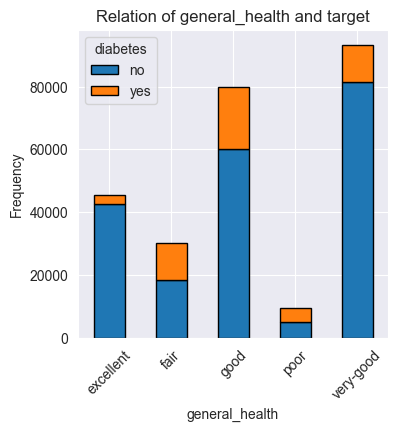

In [215]:
plot_categorical_relation(data_clean, 'general_health')

For the feature *general_health*, individuals with lower values, such as poor and fair, tend to have a higher proportion of diabetes cases.

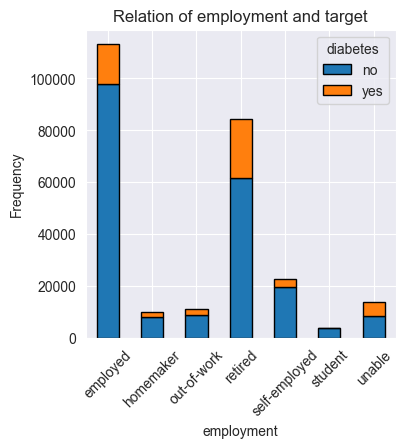

In [216]:
plot_categorical_relation(data_clean, 'employment')

For the feature *employment*, individuals that are not working, such as retired and unable, tend to have a higher proportion of diabetes cases.

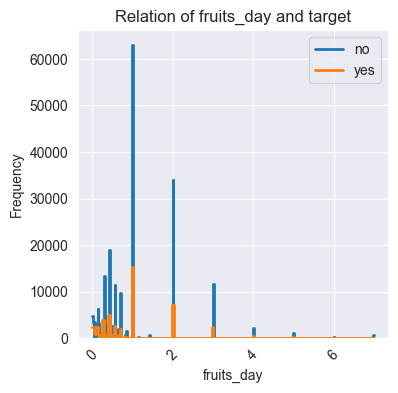

In [276]:
plot_continuous_relation(data_clean, 'fruits_day')

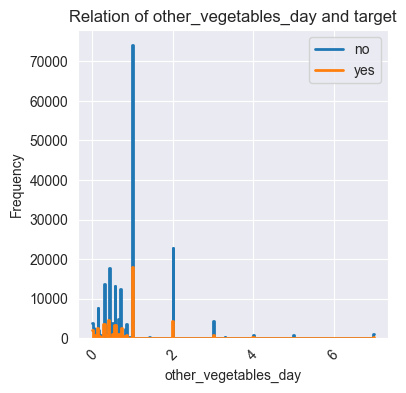

In [277]:
plot_continuous_relation(data_clean, 'other_vegetables_day')

Even if both the features fruits_day and other_vegetables_day scored high, there is only an unclear pattern observable.

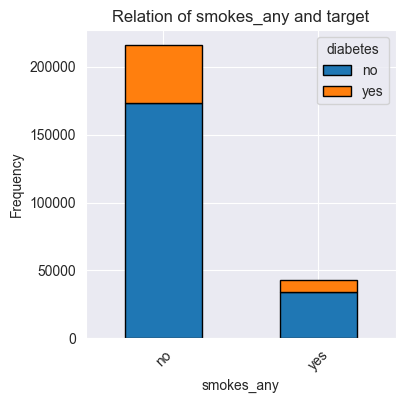

In [219]:
plot_categorical_relation(data_clean, 'smokes_any')

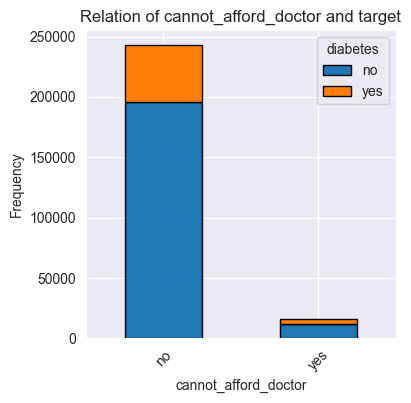

In [220]:
plot_categorical_relation(data_clean, 'cannot_afford_doctor')

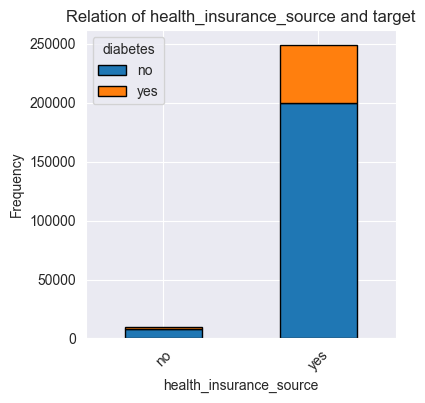

In [221]:
plot_categorical_relation(data_clean, 'health_insurance_source')

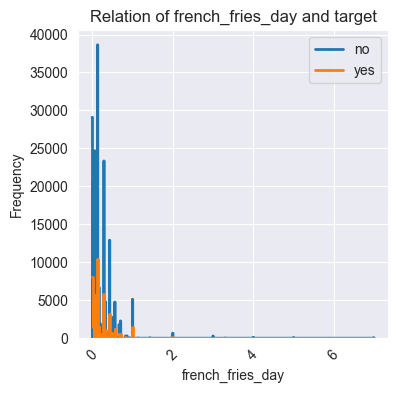

In [222]:
plot_continuous_relation(data_clean, 'french_fries_day')

For all the low scoring variables there is no pattern observable. We remove them from the dataset.

In [120]:
data_clean = data_clean.drop(columns=['smokes_any', 'health_insurance_source', 'cannot_afford_doctor', 'french_fries_day'])
data_clean.shape

(247435, 32)

In [121]:
data_selected = data_clean.copy()

## Modeling
In this section we will create, tune and compare different classification models. Since the dataset is unbalanced and very challenging, we use sampling techniques, hyperparameter tuning and ensemble. We create a baseline of each model and check if we get improvements at each step. Given the unbalanced distribution of the target, we focus on the metric f1_macro. This metric takes into consideration both the precision and the recall and applies the same weight to both classes.

In [225]:
data_selected

,state,gender,age,ethnicity,marital,education,employment,general_health,depressive_disorder,bmi_cat,...,smoked100,fruits_day,fruits_juice_day,green_vegetables_day,other_vegetables_day,potatoes_day,diabetes,mental_health_cat,physical_health_cat,drink_week_cat
0,1.00,female,70-79,white,married,high-school,retired,poor,no,underweight,...,yes,1.00,0.00,0.57,1.00,0.14,no,5-10,15-20,none
2,1.00,female,70-79,black,widowed,high-school,retired,very-good,no,over,...,no,1.00,0.00,0.00,0.43,0.14,yes,none,none,none
3,1.00,female,60-69,white,married,high-school,retired,very-good,no,obese,...,no,0.43,0.71,0.10,0.71,0.27,yes,5-10,none,1
5,1.00,male,>=80,white,married,some-college,retired,good,no,normal,...,yes,0.29,0.00,0.14,0.14,0.14,no,none,none,none
6,1.00,male,60-69,white,married,college,unable,good,yes,obese,...,no,0.40,0.03,0.43,0.29,0.07,no,none,>25,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438685,78.00,male,50-59,black,single,high-school,out-of-work,good,no,normal,...,no,0.57,0.00,0.43,1.00,0.07,yes,none,none,none
438686,78.00,male,18-29,black,single,college,employed,very-good,no,over,...,no,1.00,1.00,0.29,0.43,0.00,no,none,1-5,1
438687,78.00,male,60-69,hispanic,separated,not-high-school,retired,fair,no,normal,...,no,0.50,2.00,2.00,0.71,0.14,yes,none,none,3
438690,78.00,male,50-59,black,married,college,retired,very-good,no,obese,...,no,2.00,0.00,0.29,1.00,0.14,no,none,none,3


In [122]:
data_encoded = data_selected.copy()

le = LabelEncoder()
for column in data_encoded.select_dtypes(include=['object', 'category']).columns:
    data_encoded[column] = le.fit_transform(data_encoded[column])

X = data_encoded.drop(columns=['diabetes'])
y = data_encoded['diabetes']

The classification models we use—Logistic Regression, Multi-layer Perceptron, Random Forest, XGBoost, and CatBoost—are based on different algorithms and have diverse methodological foundations.

In [115]:
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed) #Shuffled StratifiedKFold

models_with_scaling = {
    'Logistic Regression': LogisticRegression(random_state=random_seed),
    'MLP': MLPClassifier(early_stopping=True, random_state=random_seed)
}

models_without_scaling = {
    'Random Forest': RandomForestClassifier(random_state=random_seed),
    'XGBoost': XGBClassifier(random_state=random_seed),
    'CatBoost': CatBoostClassifier(verbose=False, random_state=random_seed) #iterations=100, learning_rate=0.1, depth=6, 
}

In [116]:
def evaluate_results(mean_f1_scores):
    overall_mean_f1 = np.mean(list(mean_f1_scores.values()))
    print(f'\nOverall mean F1 score across all models: {overall_mean_f1:.4f}')
    
    plt.figure(figsize=(8, 6))
    plt.bar(mean_f1_scores.keys(), mean_f1_scores.values())
    plt.ylabel('F1 macro Score')
    plt.title('Model')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    for i, (name, score) in enumerate(mean_f1_scores.items()):
        plt.text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom')
    
    plt.show()

### Baseline
We use pipelines to perform different tasks. Logistic regression and Multi-layer Perceptron need value scaling to perform better. We use cross validation and stratifiedKFold with shuffle to test different splits and the generalizability of the models.


Overall mean F1 score across all models: 0.6246


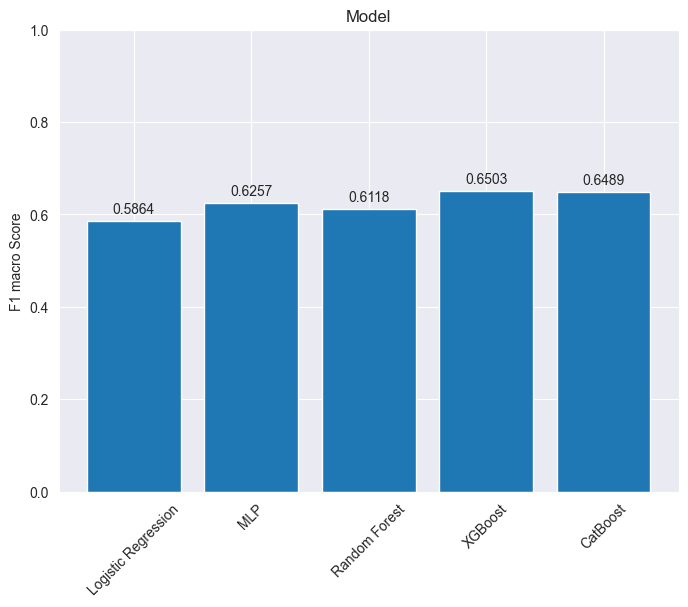

In [123]:
pipelines_with_scaling = {}
for name, model in models_with_scaling.items():
    pipeline = imPipeline([ #Creates pipeline
        ('scaler', StandardScaler()),   #Creates Scalar
        ('classifier', model)
    ])
    pipelines_with_scaling[name] = pipeline

pipelines_without_scaling = {}
for name, model in models_without_scaling.items():
    pipeline = imPipeline([
        ('classifier', model)
    ])
    pipelines_without_scaling[name] = pipeline

all_pipelines = {**pipelines_with_scaling, **pipelines_without_scaling}

mean_f1_scores = {}
for name, model in all_pipelines.items():
    scores = cross_val_score(model, X, y, cv=skf5, scoring='f1_macro') #Cross validation
    mean_f1_scores[name] = scores.mean()
    
evaluate_results(mean_f1_scores)

With no sampling technique applied XGBoost performs better with a score of 0.6495. The mean of all scores is 0.6245.

### Oversampling and Undersampling
For these purpose we use common techniques, such as SMOTE (Synthetic Minority Over-sampling Technique) for oversampling, ENN (Edited Nearest Neighbors) for undersampling and SMOTEENN which is a combination of the two.
SMOTE works by generating synthetic examples of the minority class through interpolation of existing instances, which helps to balance the class distribution.
ENN works by analyzing the nearest neighbors of each instance and removing instances that are misclassified by a majority of their neighbors, thereby improving the quality of the dataset.
SMOTEENN combines SMOTE and ENN to handle class imbalance and reduce noise simultaneously. 
It is important to mention that these techniques have to be applied only on the training set and can lead to overfitting otherwise. It is important that the testing set keeps the original distribution of the target. We therefore use pipelines to apply each step at each cross validation fold, instead of on the entire dataset.


Overall mean F1 score across all models: 0.6386


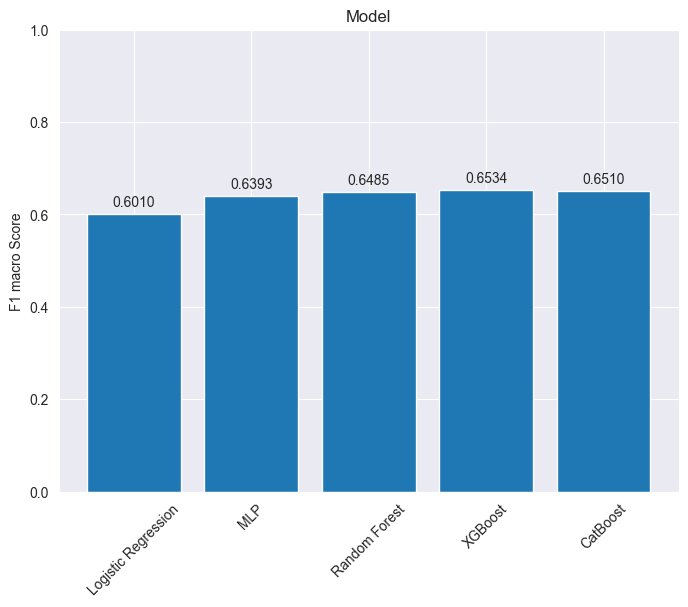

In [72]:
smote = SMOTE(random_state=random_seed) #Oversampling

pipelines_with_scaling = {}
for name, model in models_with_scaling.items():
    pipeline = imPipeline([
        ('smote', smote),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipelines_with_scaling[name] = pipeline

pipelines_without_scaling = {}
for name, model in models_without_scaling.items():
    pipeline = imPipeline([
        ('smote', smote),
        ('classifier', model)
    ])
    pipelines_without_scaling[name] = pipeline

all_pipelines = {**pipelines_with_scaling, **pipelines_without_scaling}

mean_f1_scores = {}
for name, model in all_pipelines.items():
    scores = cross_val_score(model, X, y, cv=skf5, scoring='f1_macro')
    mean_f1_scores[name] = scores.mean()
    
evaluate_results(mean_f1_scores)

Applying oversampling we see a slight improvement in the performance of all the models. XGBoost remains the best scoring model and the mean of all scores increases to 0.6386.


Overall mean F1 score across all models: 0.6804


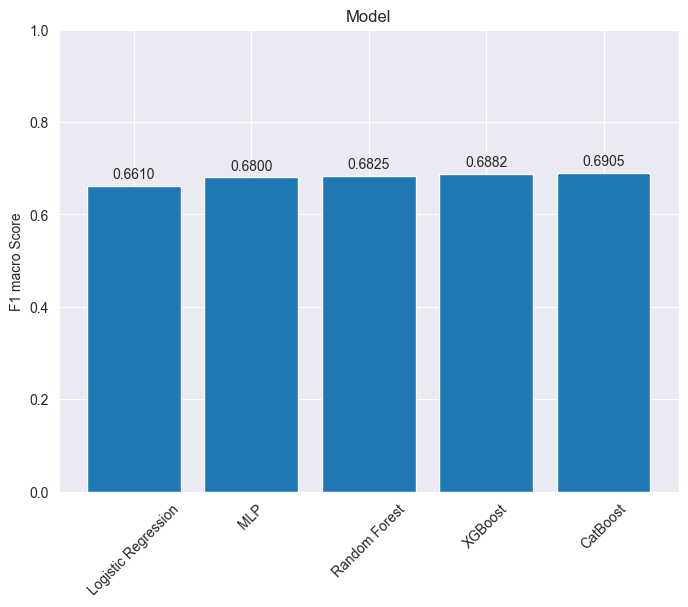

In [124]:
enn = EditedNearestNeighbours() #Undersampling

pipelines_with_scaling = {}
for name, model in models_with_scaling.items():
    pipeline = imPipeline([
        ('enn', enn),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipelines_with_scaling[name] = pipeline

pipelines_without_scaling = {}
for name, model in models_without_scaling.items():
    pipeline = imPipeline([
        ('enn', enn),
        ('classifier', model)
    ])
    pipelines_without_scaling[name] = pipeline

all_pipelines = {**pipelines_with_scaling, **pipelines_without_scaling}

mean_f1_scores = {}
for name, model in all_pipelines.items():
    scores = cross_val_score(model, X, y, cv=skf5, scoring='f1_macro')
    mean_f1_scores[name] = scores.mean()
    
evaluate_results(mean_f1_scores)

By applying undersampling we see a greater improvement in model performance. The scores are better than the baseline and compared to the results after oversampling. Catboost performs better with the highest score of 0.6909 and the mean of all scores increases to 0.6802.


Overall mean F1 score across all models: 0.6165


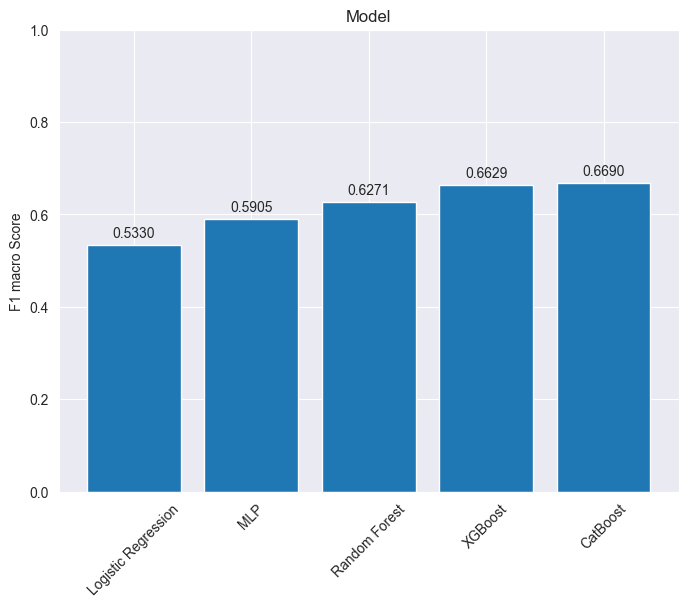

In [74]:
smoteenn = SMOTEENN(random_state=random_seed) #Oversampling and Undersampling

pipelines_with_scaling = {}
for name, model in models_with_scaling.items():
    pipeline = imPipeline([
        ('smoteenn', smoteenn),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipelines_with_scaling[name] = pipeline

pipelines_without_scaling = {}
for name, model in models_without_scaling.items():
    pipeline = imPipeline([
        ('smoteenn', smoteenn),
        ('classifier', model)
    ])
    pipelines_without_scaling[name] = pipeline

all_pipelines = {**pipelines_with_scaling, **pipelines_without_scaling}

mean_f1_scores = {}
for name, model in all_pipelines.items():
    scores = cross_val_score(model, X, y, cv=skf5, scoring='f1_macro')
    mean_f1_scores[name] = scores.mean()
    
evaluate_results(mean_f1_scores)

Using both undersampling and oversampling does not improve further the results. In fact, we get a some results that are worse than the baseline and some that are slightly higher than oversampling alone. The mean score is 0.6165. Undersampling with ENN is the technique that performed better.

### Hyperparameter tuning
We want know to try differ hyperparameters for each model. We use undersampling as it returned better results and gridsearch to try different combination. Since we apply undersampling at each fold, we avoid hyperparameters that aim at improving results for class imbalance. We are not focusing too much one the single model features importance at this point, since in the next step we are using an ensemble model composed by the basic ones. In previous section we focused on analysing the feature scores.

In [84]:
skf3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

 Logistic Regression is a statistical model which predicts the probability that a given input belongs to a particular class. The model uses a logistic function to map predicted values to probabilities. We try different parameters for the regularization strength, the regularization type, and the number of iterations.

In [76]:
lr_param_grid = {
    'classifier__C': [1, 10],   #Regularization strength
    'classifier__penalty': ['l1', 'l2'],    #Regularization type
    'classifier__max_iter': [50, 100, 150]  #Maximum number of iterations
}

lr_pipeline = imPipeline([
    ('enn', enn),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=random_seed))
])

lr_grid_search = GridSearchCV(estimator=lr_pipeline, param_grid=lr_param_grid, scoring='f1_macro', cv=skf3, n_jobs=-1)
lr_grid_search.fit(X, y)
lr_best = lr_grid_search.best_estimator_

print(f'\nThe best hyperparameters for Logistic regression are: {lr_grid_search.best_params_}')
print(f'\nBest F1 macro score: {lr_grid_search.best_score_:.4f}')


The best hyperparameters for Logistic regression are: {'classifier__C': 10, 'classifier__max_iter': 50, 'classifier__penalty': 'l2'}

Best F1 macro score: 0.6603


The score of the logistic regression increases to 0.6603.

Random Forest is an ensemble learning method that builds multiple decision trees and merges them together to get a more accurate and stable prediction. Each tree in the forest is trained on a random subset of the data, and the final prediction is made by taking the majority vote from all the trees. Random Forest is highly effective at reducing overfitting and improving accuracy. We try different parameters for the number of estimators, the depth of the trees and the number of samples to splits.

In [77]:
rf_param_grid = {
    'classifier__n_estimators': [200, 250], #Number of trees
    'classifier__max_depth': [20, 30],  #Maximum depth of the tree
    'classifier__min_samples_split': [8, 10, 12],   #Minimum number of samples to split an internal node
}

rf_pipeline = imPipeline([
    ('enn', enn),
    ('classifier', RandomForestClassifier(random_state=random_seed))
])

rf_grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, scoring='f1_macro', cv=skf3, n_jobs=-1)
rf_grid_search.fit(X, y)
rf_best = rf_grid_search.best_estimator_

print(f'\nThe best hyperparameters for Random forest are: {rf_grid_search.best_params_}')
print(f'\nBest F1 macro score: {rf_grid_search.best_score_:.4f}')


The best hyperparameters for Random forest are: {'classifier__max_depth': 20, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 200}

Best F1 macro score: 0.6829


The score of the random forest slightly improves to 0.6829.

A Multi-Layer Perceptron is a type of feedforward artificial neural network that consists of multiple layers of nodes connected in a directed graph. It includes an input layer, one or more hidden layers, and an output layer. Each neuron uses a nonlinear activation function to process inputs and pass information forward through the network. We try different parameters for the sizes of hidden layers, the alpha value and the number of iteration.

In [78]:
mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(100,), (50, 50), (100, 100)],  #Size of hidden layers
    'classifier__alpha': [0.01, 0.1],  #Regularization term
    'classifier__max_iter': [600, 800], #Maximum number of iterations
}

mlp_pipeline = imPipeline([
    ('enn', enn),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(early_stopping=True, random_state=random_seed))
])

mlp_grid_search = GridSearchCV(estimator=mlp_pipeline, param_grid=mlp_param_grid, scoring='f1_macro', cv=skf3, n_jobs=-1)
mlp_grid_search.fit(X, y)
mlp_best = mlp_grid_search.best_estimator_

print(f'\nThe best hyperparameters for Multi-layer Perceptron are: {mlp_grid_search.best_params_}')
print(f'\nBest F1 macro score: {mlp_grid_search.best_score_:.4f}')


The best hyperparameters for Multi-layer Perceptron are: {'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__max_iter': 600}

Best F1 macro score: 0.6820


The score of the mult-layer perceptron slightly improves to 0.6820.

XGBoost is a powerful gradient boosting algorithm that builds an ensemble of decision trees in a sequential manner, where each new tree corrects the errors of the previous ones. It uses a technique called boosting, which focuses on improving the model’s performance by optimizing a loss function. We try different parameters for the number of estimators, the learning rate and the max depth.

In [79]:
xgb_param_grid = {
    'classifier__n_estimators': [150, 200], #Number of boosting rounds
    'classifier__learning_rate': [0.1, 0.2, 0.3],    #Step size shrinkage
    'classifier__max_depth': [2, 3],    #Maximum depth of a tree          
}

xgb_pipeline = imPipeline([
    ('enn', enn),
    ('classifier', XGBClassifier(random_state=random_seed))
])

xgb_grid_search = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param_grid, scoring='f1_macro', cv=skf3, n_jobs=-1)
xgb_grid_search.fit(X, y)
xgb_best = xgb_grid_search.best_estimator_

print(f'\nThe best hyperparameters for XGBoost are: {xgb_grid_search.best_params_}')
print(f'\nBest F1 macro score: {xgb_grid_search.best_score_:.4f}')


The best hyperparameters for XGBoost are: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 2, 'classifier__n_estimators': 200}

Best F1 macro score: 0.6900


The score of XGBoost slightly improves to 0.6900.

CatBoost is a gradient boosting algorithm that is particularly well-suited for categorical data. It also addresses some of the common challenges in boosting algorithms, such as overfitting and model interpretability. 

In [83]:
cat_param_grid = {
    'classifier__iterations': [200, 300, 350],  #Number of iterations
    'classifier__depth': [4, 6], #Depth of a tree
    'classifier__learning_rate': [0.1, 0.2]   #Learning rate
}

cat_pipeline = imPipeline([
    ('enn', enn),
    ('classifier', CatBoostClassifier(verbose=False, random_state=random_seed))
])

cat_grid_search = GridSearchCV(estimator=cat_pipeline, param_grid=cat_param_grid, scoring='f1_macro', cv=skf3, n_jobs=-1)
cat_grid_search.fit(X, y)
cat_best = cat_grid_search.best_estimator_

print(f'\nThe best hyperparameters for CatBoost are: {cat_grid_search.best_params_}')
print(f'\nBest F1 macro score: {cat_grid_search.best_score_:.4f}')


The best hyperparameters for CatBoost are: {'classifier__depth': 4, 'classifier__iterations': 350, 'classifier__learning_rate': 0.2}

Best F1 macro score: 0.6909


The score of CatBoost stays at 0.6909.

### Ensemble
Now that we have the best version of each model separately we create a meta classifier composed by these base model. With a voting classifier each model makes its own classifications and at the end a voting system is applied to make the final choice.

In [85]:
models_with_scaling = {
    'Logistic Regression': lr_best,
    'MLP': mlp_best
}

models_without_scaling = {
    'Random Forest': rf_best,
    'XGBoost': xgb_best,
    'CatBoost': cat_best
}

pipelines_with_scaling = {}
for name, model in models_with_scaling.items():
    pipeline = imPipeline([
        ('enn', enn),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipelines_with_scaling[name] = pipeline

pipelines_without_scaling = {}
for name, model in models_without_scaling.items():
    pipeline = imPipeline([
        ('enn', enn),
        ('classifier', model)
    ])
    pipelines_without_scaling[name] = pipeline

all_pipelines = {**pipelines_with_scaling, **pipelines_without_scaling}

voting_clf = VotingClassifier(estimators=[(name, pipeline) for name, pipeline in all_pipelines.items()], voting='hard', n_jobs=-1)

scores = cross_val_score(voting_clf, X, y, cv=skf5, scoring='f1_macro')
print(f"F1 Macro Score from Cross-Validation: {scores} with mean {scores.mean():.4f}")

F1 Macro Score from Cross-Validation: [0.65932261 0.65290715 0.65666602] with mean 0.6563


The mean of the scores is 0.6563 and the model does not perform better than CatBoost alone. We therefore evaluate the base model instead of the voting classifier.

### Evaluation
Now we use the most common metrics to evaluate a classification model when the target is unbalanced. These include the classification report with the scores for each class, the confusion matrix and the roc-auc and precision-recall curve.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_resamp, y_train_resamp = enn.fit_resample(X_train, y_train)
cat_best.fit(X_train_resamp, y_train_resamp)
y_pred = cat_best.predict(X_test)

In [105]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     41382
           1       0.40      0.75      0.52     10045

    accuracy                           0.73     51427
   macro avg       0.66      0.74      0.67     51427
weighted avg       0.82      0.73      0.76     51427


From the classification report we see that the majority is classified well, whereas the minority class is not classified very well. The recall of 0.75 shows that a good part of positive cases are identified, but the precision of 0.40 also indicates a high number of false positives.

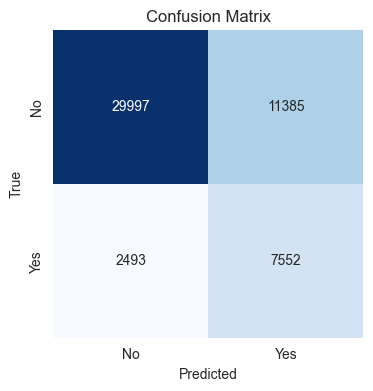

In [107]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In fact from the confusion matrix we see how most of the negative cases are correctly classified, but 11385 instances are misclassified as positive. Around two thirds of the cases are correctly predicted.

In [90]:
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_prob = cat_best.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
print(auc(fpr, tpr))

0.8135888140889558


Calculating the area under the curve we get a value of 0.8136. Unfortunately due to the unbalanced nature of the dataset this value can be misleading.

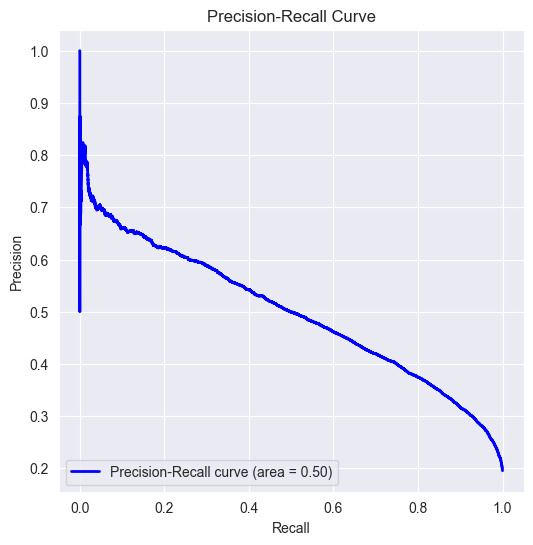

In [109]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
#plt.show()
plt.savefig('curve.png')

Finally, we plot the precision-recall curve, which is more adequate in these cases. The area under the curve in this case is 0.50. The precision, recall and f1 scores differences show that the unbalance is critical and that the features may not be enough informative.
Given the minority proportion of 0.19 we reached a reasonable result using very challenging data collected with interviews.

## Conclusion
In this notebook, we developed a model for predicting diabetes using data collected from a questionnaire. The process began with a thorough analysis of the dataset, where we selected features that were likely related to diabetes, leveraging both domain knowledge and questionnaire documentation. Following this, we applied standard data preprocessing and cleaning techniques to prepare the data for analysis and modeling.

We then explored various feature selection methods aimed at improving model performance and reducing complexity. These techniques provided valuable insights into the relationships between the selected features and the target variable. We experimented with different classification models and sampling strategies, comparing their performance using the F1 macro score. Each model underwent hyperparameter tuning through grid searches, and we also tested a voting classifier that combined the best-performing models. The final model was evaluated using metrics suitable for unbalanced datasets, such as the classification report, confusion matrix, and ROC AUC. 

One of the main challenges in this project was dealing with the unbalanced nature of the dataset, as well as the inherent limitations of using questionnaire data, which may not always reveal strong patterns for predicting diabetes. Future improvements could include adjusting and calibrating the probabilities of class predictions, employing data augmentation techniques, or utilizing model interpretability tools to gain deeper insights into the model's decision-making process.